In [84]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"


plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

In [85]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [86]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    Cont = np.array([])
    SBJ = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta0 = prms['delta0'].values[i]
        delta1 = prms['delta1'].values[i]
        t0 = prms['t0'].values[i]
        
        if model == 'exp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 * np.exp(-lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'hyp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 / (1 + lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'ddm':
            b0 = prms['b0'].values[i]
            ub = lambda t: b0
            lb = lambda t: -1*ub(t)   

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)
        contrast = sbj_data.contrast.values

        rt = []

        for c in contrast:
            delta = delta0 - delta1*np.log(c)
#             delta = delta0 - delta1*np.log((c/100 - 0.025)/(c/100 + 0.025))
            rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))

        RT = np.concatenate([RT, rt])
        Cont = np.concatenate([Cont, contrast])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'rt': np.abs(RT),
                         'accuracy': RT>0,
                         'contrast': Cont,
                         'g_contrast': Cont//10*10}) 

In [87]:
data = pd.read_csv('../../_Data/Study1.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data.event == 3]
data = data[data['Duration']<data['rt']].reset_index(drop=True)
data['rt']/=1000
data['Duration']/=1000

data['g_contrast'] = data['contrast']//10*10

data_speed = data[data.condition == 'speed'].reset_index(drop=True)
data_accuracy = data[data.condition == 'accuracy'].reset_index(drop=True)

In [88]:
data['g_contrast'].nunique()

10

In [89]:
hyp_speed = pd.read_csv('_prms/hyp_speed.csv')
hyp_accuracy = pd.read_csv('_prms/hyp_accuracy.csv')
exp_speed = pd.read_csv('_prms/exp_speed.csv')
exp_accuracy = pd.read_csv('_prms/exp_accuracy.csv')
jddm_speed = pd.read_csv('_prms/jddm_speed.csv')
jddm_accuracy = pd.read_csv('_prms/jddm_accuracy.csv')

bhyp_speed = pd.read_csv('_prms/bhyp_speed.csv')
bhyp_accuracy = pd.read_csv('_prms/bhyp_accuracy.csv')
bexp_speed = pd.read_csv('_prms/bexp_speed.csv')
bexp_accuracy = pd.read_csv('_prms/bexp_accuracy.csv')
bddm_speed = pd.read_csv('_prms/bddm_speed.csv')
bddm_accuracy = pd.read_csv('_prms/bddm_accuracy.csv')

In [7]:
pred_hyp_sp = get_model_prediction(hyp_speed, data_speed, 'hyp')
pred_hyp_ac = get_model_prediction(hyp_accuracy, data_accuracy, 'hyp')

100%|███████████████████████████████████████████| 26/26 [00:28<00:00,  1.11s/it]


In [8]:
pred_bhyp_sp = get_model_prediction(bhyp_speed, data_speed, 'hyp')
pred_bhyp_ac = get_model_prediction(bhyp_accuracy, data_accuracy, 'hyp')

100%|███████████████████████████████████████████| 26/26 [00:24<00:00,  1.05it/s]


In [9]:
pred_exp_sp = get_model_prediction(exp_speed, data_speed, 'exp')
pred_exp_ac = get_model_prediction(exp_accuracy, data_accuracy, 'exp')

100%|███████████████████████████████████████████| 26/26 [00:41<00:00,  1.59s/it]


In [10]:
pred_bexp_sp = get_model_prediction(bexp_speed, data_speed, 'exp')
pred_bexp_ac = get_model_prediction(bexp_accuracy, data_accuracy, 'exp')

100%|███████████████████████████████████████████| 26/26 [00:36<00:00,  1.39s/it]


In [11]:
pred_jddm_sp = get_model_prediction(jddm_speed, data_speed, 'ddm')
pred_jddm_ac = get_model_prediction(jddm_accuracy, data_accuracy, 'ddm')

100%|███████████████████████████████████████████| 26/26 [00:27<00:00,  1.04s/it]


In [12]:
pred_bddm_sp = get_model_prediction(bddm_speed, data_speed, 'ddm')
pred_bddm_ac = get_model_prediction(bddm_accuracy, data_accuracy, 'ddm')

100%|███████████████████████████████████████████| 26/26 [00:20<00:00,  1.29it/s]


In [13]:
def get_rt_acc_corr(pred):
    x = [pred[pred['accuracy']==True]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [pred[(pred['accuracy']==True) & (pred['rt']<x[i])].shape[0]/pred.shape[0] for i in range(len(x))]
    return x, y

def get_rt_acc_incorr(pred):
    x = [pred[pred['accuracy']==False]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [pred[(pred['accuracy']==False) & (pred['rt']<x[i])].shape[0]/pred.shape[0] for i in range(len(x))]
    return x, y

In [14]:
def plot_data_speed():
    x = [data_speed[data_speed['correct']==1]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_speed.loc[(data_speed['correct']==1)&(data_speed['rt']<x[i])].shape[0]/data_speed.shape[0] for i in range(len(x))]
    plt.scatter(x, y, c='green', marker='x', label='Data-Correct');
    plt.plot(x, y, c='green', alpha=0.3)

    x = [data_speed[data_speed['correct']==0]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_speed.loc[(data_speed['correct']==0)&(data_speed['rt']<x[i])].shape[0]/data_speed.shape[0] for i in range(len(x))]
    plt.scatter(x, y, c='red', marker='x', label='Data-Incorrect');
    plt.plot(x, y, c='red', alpha=0.3)
    
def plot_data_accuracy():
    x = [data_accuracy[data_accuracy['correct']==1]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_accuracy[(data_accuracy['correct']==1)&(data_accuracy['rt']<x[i])].shape[0]/data_accuracy.shape[0] for i in range(len(x))]
    plt.scatter(x, y, c='green', marker='x', label='Data-Correct');
    plt.plot(x, y, c='green', alpha=0.3)

    x = [data_accuracy[data_accuracy['correct']==0]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_accuracy[(data_accuracy['correct']==0)&(data_accuracy['rt']<x[i])].shape[0]/data_accuracy.shape[0] for i in range(len(x))]
    plt.scatter(x, y, c='red', marker='x', label='Data-Incorrect');
    plt.plot(x, y, c='red', alpha=0.3);

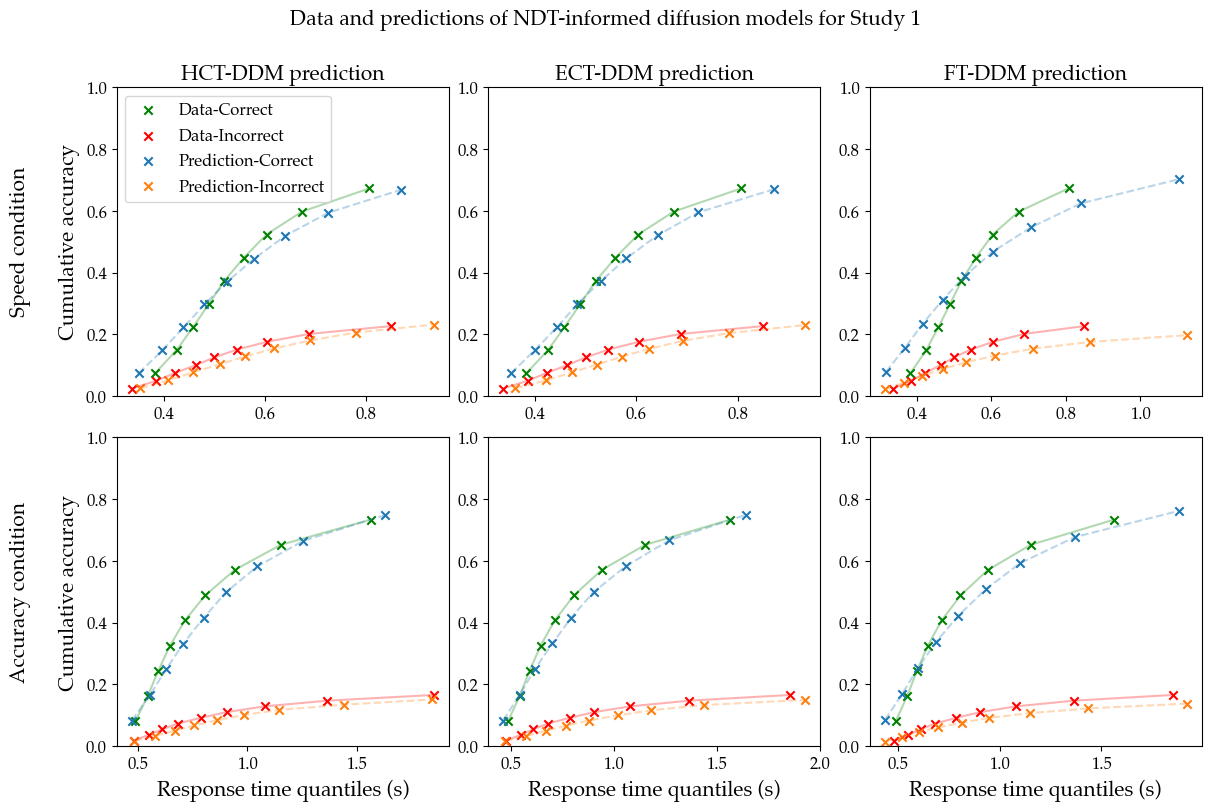

In [15]:
fig = plt.figure(figsize=(12, 8), layout='constrained')
fig.suptitle('Data and predictions of NDT-informed diffusion models for Study 1\n', size=15) # or plt.suptitle('Main title')

plt.subplot(231)
plt.title('HCT-DDM prediction')
plot_data_speed()
x, y = get_rt_acc_corr(pred_hyp_sp)
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_hyp_sp)
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0, 1)
plt.ylabel('Speed condition\n\nCumulative accuracy')
plt.legend(loc='upper left')


plt.subplot(232)
plt.title('ECT-DDM prediction')
plot_data_speed()
x, y = get_rt_acc_corr(pred_exp_sp)
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_exp_sp)
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0, 1)
# plt.legend(loc='upper left')


plt.subplot(233)
plt.title('FT-DDM prediction')
plot_data_speed()
x, y = get_rt_acc_corr(pred_jddm_sp)
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_jddm_sp)
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0, 1)
# plt.legend(loc='upper left')

plt.subplot(234)
plot_data_accuracy()
x, y = get_rt_acc_corr(pred_hyp_ac)
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_hyp_ac)
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0,1)
plt.xlabel('Response time quantiles (s)');
plt.ylabel('Accuracy condition\n\nCumulative accuracy')
# plt.legend(loc='upper left')


plt.subplot(235)
plot_data_accuracy()
x, y = get_rt_acc_corr(pred_exp_ac)
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_exp_ac)
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0,1)
plt.xlabel('Response time quantiles (s)');
# plt.legend(loc='upper left')


plt.subplot(236)
plot_data_accuracy()
x, y = get_rt_acc_corr(pred_jddm_ac)
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_jddm_ac)
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0,1)
plt.xlabel('Response time quantiles (s)');
# plt.legend(loc='upper left');
plt.savefig('_plots/S1_preds_NDT_informed.pdf', 
            transparent=True, 
            dpi=600, 
            bbox_inches='tight');

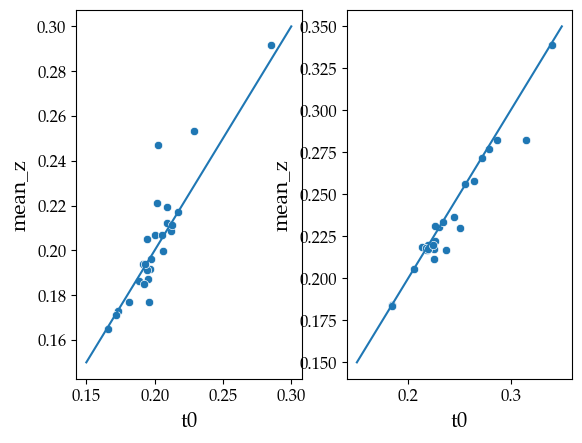

In [115]:
plt.subplot(121)
sns.scatterplot(x=hyp_speed['t0'], y=hyp_speed['mean_z']);
plt.plot(np.linspace(0.15, .3), np.linspace(0.15, .3))

plt.subplot(122)
sns.scatterplot(x=hyp_accuracy['t0'], y=hyp_accuracy['mean_z']);
plt.plot(np.linspace(0.15, .35), np.linspace(0.15, .35));